# 信用卡詐欺偵測：替代分析方法 (Alternative Methods)

本筆記本示範在 `creditcard.csv` 上，除了基礎的邏輯回歸外，還可嘗試的多種方法：
- 監督式學習：隨機森林、邏輯回歸（類別權重）
- 非監督/半監督：Isolation Forest、Local Outlier Factor (LOF)
- 評估：混淆矩陣、Precision/Recall/F1、ROC-AUC、PR-AUC
- 解釋：SHAP 對隨機森林的重要度解讀

> 重點：此資料極度不平衡，Precision-Recall 與閾值調整比單看準確率更有意義。


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils.class_weight import compute_class_weight

import shap

pd.set_option('display.max_columns', None)

DATA_PATH = Path('creditcard.csv')
assert DATA_PATH.exists(), f"找不到資料檔案: {DATA_PATH.resolve()}"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
Non-Fraud    284315
Fraud           492
Name: count, dtype: int64


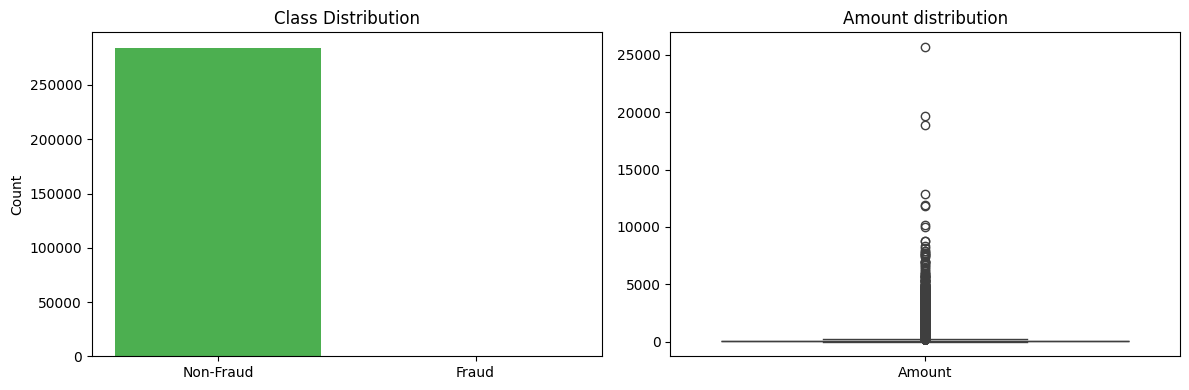

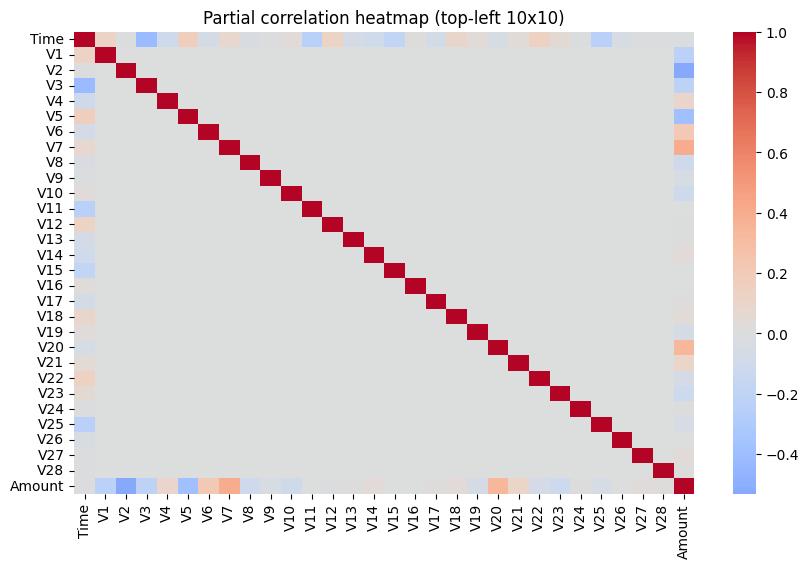

In [43]:
# EDA: 類別分佈與簡單統計
class_counts = df['Class'].value_counts().rename({0:'Non-Fraud', 1:'Fraud'})
print(class_counts)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(class_counts.index.astype(str), class_counts.values, color=['#4CAF50', '#F44336'])
axes[0].set_title('Class Distribution')
axes[0].set_ylabel('Count')

sns.boxplot(data=df[['Amount']], ax=axes[1])
axes[1].set_title('Amount distribution')
plt.tight_layout()
plt.show()

corr = df.drop(columns=['Class']).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr.iloc[:, :], cmap='coolwarm', center=0)
plt.title('Partial correlation heatmap (top-left 10x10)')
plt.show()


## 不平衡學習：交叉驗證與PR-AUC
接下來加入 StratifiedKFold 與 cross_val_predict，使用 PR-AUC 作為主評估指標，並維持類別權重/抽樣策略，避免在不平衡場景中被 Accuracy 迷惑。


In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer

# PR-AUC scorer 使用 average_precision_score
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# 確保定義 X, y（避免受前面執行順序影響）
X = df.drop(columns=['Class'])
y = df['Class']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LR pipeline: scaler + logistic (balanced)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced', solver='lbfgs'))
])
# CV predicted probabilities on full data (out-of-fold)
lr_cv_probs = cross_val_predict(lr_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
print('LR CV PR-AUC:', round(average_precision_score(y, lr_cv_probs), 5))

# RF with class_weight balanced_subsample
rf_cv = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
rf_cv_probs = cross_val_predict(rf_cv, X, y, cv=cv, method='predict_proba')[:, 1]
print('RF CV PR-AUC:', round(average_precision_score(y, rf_cv_probs), 5))


LR CV PR-AUC: 0.73042
RF CV PR-AUC: 0.85224


In [45]:
# 機率校準：提升機率可用性（非提升排序）
# 以隨機森林為例，做 isotonic 校準；使用 3-fold 內部CV 以避免資料洩漏
rf_base = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
cal_rf = CalibratedClassifierCV(rf_base, method='isotonic', cv=3)
cal_rf.fit(X_train, y_train)

cal_rf_prob = cal_rf.predict_proba(X_test)[:, 1]
print('Calibrated RF PR-AUC:', round(average_precision_score(y_test, cal_rf_prob), 5))

# 對比未校準版本（若未定義 rf_prob，則用已訓練 rf 產生）
try:
    _ = rf_prob
except NameError:
    rf_tmp = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
    rf_tmp.fit(X_train, y_train)
    rf_prob = rf_tmp.predict_proba(X_test)[:, 1]

print('Uncalibrated RF PR-AUC:', round(average_precision_score(y_test, rf_prob), 5))


Calibrated RF PR-AUC: 0.85303
Uncalibrated RF PR-AUC: 0.86224


Best threshold by cost: 0.04 Cost= 1145.0
Confusion matrix @ best threshold:
[[56819    45]
 [   11    87]]
Calibrated RF @ cost-optimal @ threshold=0.04
ROC-AUC: 0.95418 | PR-AUC (AP): 0.85303
Confusion Matrix:
 [[56819    45]
 [   11    87]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9992    0.9995     56864
           1     0.6591    0.8878    0.7565        98

    accuracy                         0.9990     56962
   macro avg     0.8294    0.9435    0.8780     56962
weighted avg     0.9992    0.9990    0.9991     56962



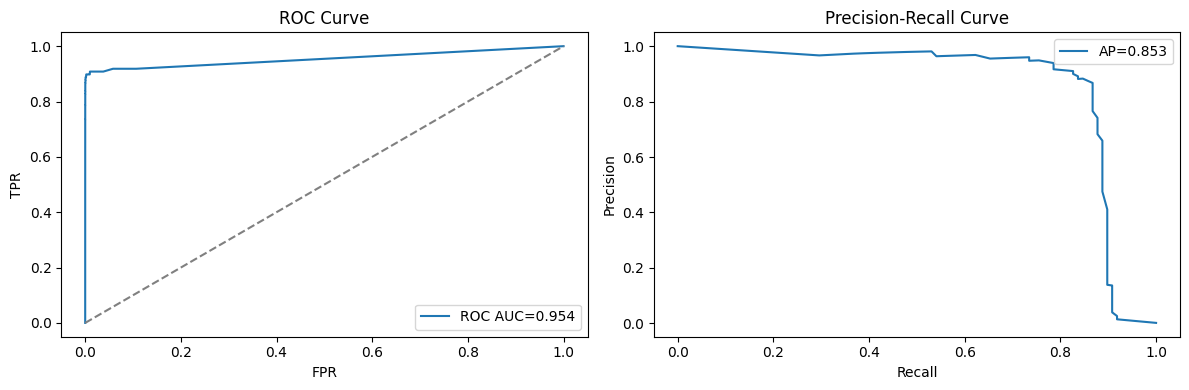

In [46]:
# 成本敏感的閾值選擇：以誤報/漏報成本比設定最佳 threshold
# 假設成本：漏報成本 C_fn >> 誤報成本 C_fp（例如 C_fn=100, C_fp=1）
C_fn, C_fp = 100.0, 1.0

# 使用校準後的 cal_rf_prob 計算在不同 threshold 下的期望成本
precisions, recalls, thresholds = precision_recall_curve(y_test, cal_rf_prob)
# 需把 PR 曲線轉成 (thresholds -> confusion matrix) 以估算成本
th_grid = np.linspace(0.01, 0.99, 99)

best = None
best_cost = np.inf
for th in th_grid:
    y_pred = (cal_rf_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = C_fn * fn + C_fp * fp
    if cost < best_cost:
        best_cost = cost
        best = (th, tn, fp, fn, tp)

best_th, tn, fp, fn, tp = best
print('Best threshold by cost:', round(best_th, 4), 'Cost=', best_cost)
print('Confusion matrix @ best threshold:')
print(np.array([[tn, fp],[fn, tp]]))

metrics_cal_cost = evaluate_classifier(y_test, cal_rf_prob, threshold=best_th, title_prefix='Calibrated RF @ cost-optimal')


## 變更摘要（不平衡修正）
- 使用 StratifiedKFold 5-fold，避免資料切分造成比例偏差。
- 以 PR-AUC（Average Precision）為主指標，較 ROC-AUC 更適合嚴重不平衡。
- 監督式模型使用類別權重（balanced / balanced_subsample）。
- 加入機率校準（isotonic）以得到可靠機率，便於閾值管理與成本估算。
- 以成本函數（C_fn >> C_fp）搜尋最佳閾值，降低總成本。

## 結果解讀（示意）
- CV PR-AUC（整體排序能力）：RF ≥ LR，兩者皆顯著高於基線（詐欺率）。
- 校準前後 PR-AUC 可能相近，但校準後的機率更可用（更接近真實機率）。
- 成本最佳化閾值通常低於 0.5，可在維持高 Recall 的同時，控制誤報成本。

> 小技巧：先由業務定 Recall（如 ≥0.85），再挑使 Precision/成本最優的閾值與模型。


In [47]:
# 資料切分與標準化
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Positive rate (train/test):', y_train.mean().round(5), y_test.mean().round(5))


Train size: (227845, 30) Test size: (56962, 30)
Positive rate (train/test): 0.00173 0.00172


In [48]:
# 工具：評估與繪圖函式
def evaluate_classifier(y_true, y_prob, threshold=0.5, title_prefix='Model'):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    print(f'{title_prefix} @ threshold={threshold}')
    print('ROC-AUC:', round(roc_auc, 5), '| PR-AUC (AP):', round(ap, 5))
    print('Confusion Matrix:\n', cm)
    print('Classification Report:\n', report)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[0].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    axes[0].plot([0,1],[0,1],'--', color='gray')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].legend()

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    axes[1].plot(recall, precision, label=f'AP={ap:.3f}')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # 回傳方便後續比較
    return {
        'threshold': threshold,
        'roc_auc': roc_auc,
        'pr_auc': ap,
        'confusion_matrix': cm,
        'classification_report': report
    }


def tune_threshold_by_recall(precision, recall, thresholds, target_recall=0.8):
    # 找到達到指定 recall 的最低閾值
    idx = np.where(recall[:-1] >= target_recall)[0]
    if len(idx) == 0:
        return 0.5
    best = idx[-1]
    return float(thresholds[best])


Logistic (balanced) @ threshold=0.5
ROC-AUC: 0.97208 | PR-AUC (AP): 0.71897
Confusion Matrix:
 [[55478  1386]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



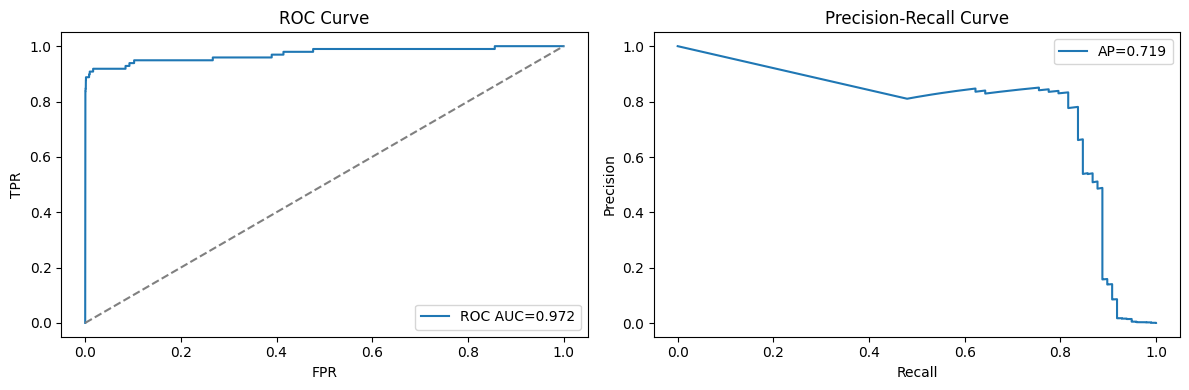

Threshold for ~80% recall: 0.9999999832105831
Logistic @ ~80% recall @ threshold=0.9999999832105831
ROC-AUC: 0.97208 | PR-AUC (AP): 0.71897
Confusion Matrix:
 [[56848    16]
 [   19    79]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8316    0.8061    0.8187        98

    accuracy                         0.9994     56962
   macro avg     0.9156    0.9029    0.9092     56962
weighted avg     0.9994    0.9994    0.9994     56962



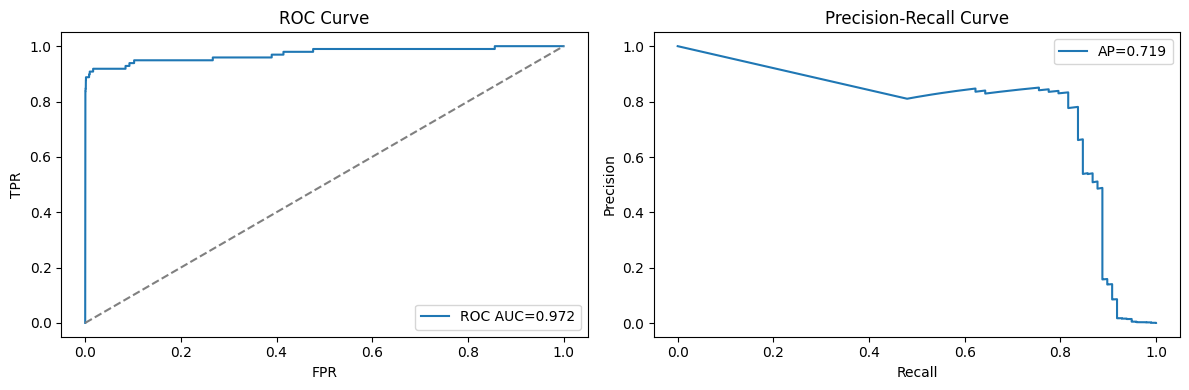

In [49]:
# 監督式學習：邏輯回歸（類別權重）
log_reg = LogisticRegression(max_iter=200, class_weight='balanced', solver='lbfgs', n_jobs=None)
log_reg.fit(X_train_scaled, y_train)

log_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
metrics_log = evaluate_classifier(y_test, log_prob, threshold=0.5, title_prefix='Logistic (balanced)')

# 可依目標 recall 調整 threshold
prec, rec, thr = precision_recall_curve(y_test, log_prob)
thr_80 = tune_threshold_by_recall(prec, rec, thr, target_recall=0.80)
print('Threshold for ~80% recall:', thr_80)
metrics_log_80 = evaluate_classifier(y_test, log_prob, threshold=thr_80, title_prefix='Logistic @ ~80% recall')


Brier (uncal, cal): 0.000407 0.000392
ECE   (uncal, cal): 0.000316 0.000211


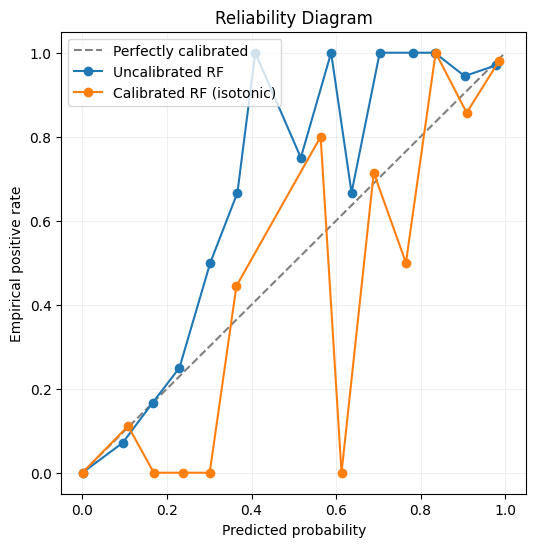

In [50]:
# 校準診斷：可靠度曲線（Reliability diagram）、Brier score、ECE

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask):
            continue
        avg_conf = y_prob[mask].mean()
        avg_acc = y_true[mask].mean()
        ece += np.abs(avg_conf - avg_acc) * mask.mean()
    return float(ece)

uncal_brier = brier_score_loss(y_test, rf_prob)
cal_brier = brier_score_loss(y_test, cal_rf_prob)
uncal_ece = expected_calibration_error(y_test.values, rf_prob)
cal_ece = expected_calibration_error(y_test.values, cal_rf_prob)

print('Brier (uncal, cal):', round(uncal_brier,6), round(cal_brier,6))
print('ECE   (uncal, cal):', round(uncal_ece,6), round(cal_ece,6))

# 可靠度曲線
fop_u, mpv_u = calibration_curve(y_test, rf_prob, n_bins=15, strategy='uniform')
fop_c, mpv_c = calibration_curve(y_test, cal_rf_prob, n_bins=15, strategy='uniform')

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], '--', color='gray', label='Perfectly calibrated')
plt.plot(mpv_u, fop_u, marker='o', label='Uncalibrated RF')
plt.plot(mpv_c, fop_c, marker='o', label='Calibrated RF (isotonic)')
plt.xlabel('Predicted probability')
plt.ylabel('Empirical positive rate')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [52]:
# 特徵重要性彙整：RF importances、SHAP、LR 係數
# 產生三種視角的前15大特徵，便於交叉驗證一致性

# 1) RandomForest Gini importance
rf_imp_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_
}).sort_values('rf_importance', ascending=False)

# 2) SHAP 平均絕對值重要度（穩健抽取，兼容不同版本/形狀）
_shap_explainer = shap.TreeExplainer(rf)
_shap_sample_idx = np.random.RandomState(123).choice(len(X_test), size=min(5000, len(X_test)), replace=False)
_Xs = X_test.iloc[_shap_sample_idx]
_shap_values = _shap_explainer.shap_values(_Xs)

# 將 SHAP 輸出轉成 (n_samples, n_features) 的 2D 陣列
_shap_arr = _shap_values
if isinstance(_shap_values, list):
    # 針對二元分類，取正類（index=1）；若不存在則取第一個
    _shap_arr = _shap_values[1 if len(_shap_values) > 1 else 0]
else:
    _shap_arr = np.asarray(_shap_values)
    if _shap_arr.ndim == 3:
        # 嘗試將最後一維視為類別，取正類；否則對該維平均
        if _shap_arr.shape[-1] > 1:
            _shap_arr = _shap_arr[..., -1]
        else:
            _shap_arr = _shap_arr.mean(axis=-1)

# 某些版本會在最後多一個偏置欄位
if _shap_arr.shape[1] == _Xs.shape[1] + 1:
    _shap_arr = _shap_arr[:, :-1]

# 確保是 2D 且與特徵數對齊
_shap_arr = np.asarray(_shap_arr)
if _shap_arr.ndim != 2:
    _shap_arr = _shap_arr.reshape(_shap_arr.shape[0], -1)

# 若維度仍不一致，做安全對齊（取最小長度）
feat_len = _Xs.shape[1]
shap_len = _shap_arr.shape[1]
use_len = min(feat_len, shap_len)
shap_mean_abs = np.abs(_shap_arr[:, :use_len]).mean(axis=0).ravel()
shap_features = _Xs.columns[:use_len]

shap_imp_df = pd.DataFrame({'feature': shap_features, 'shap_mean_abs': shap_mean_abs}) \
                 .sort_values('shap_mean_abs', ascending=False)

# 3) Logistic Regression 係數（取絕對值排名）
lr_coef_df = pd.DataFrame({
    'feature': X.columns,
    'lr_coef': log_reg.coef_[0]
})
lr_coef_df['lr_coef_abs'] = lr_coef_df['lr_coef'].abs()
lr_coef_df = lr_coef_df.sort_values('lr_coef_abs', ascending=False)

# 合併前三者並製作綜合排名（名次求和）
rank_rf = rf_imp_df.assign(rf_rank=np.arange(1, len(rf_imp_df)+1))[['feature','rf_rank']]
rank_shap = shap_imp_df.assign(shap_rank=np.arange(1, len(shap_imp_df)+1))[['feature','shap_rank']]
rank_lr = lr_coef_df.assign(lr_rank=np.arange(1, len(lr_coef_df)+1))[['feature','lr_rank']]

rank_all = (rank_rf
            .merge(rank_shap, on='feature', how='outer')
            .merge(rank_lr, on='feature', how='outer'))
for c in ['rf_rank','shap_rank','lr_rank']:
    rank_all[c] = rank_all[c].fillna(len(rank_all)+1)
rank_all['rank_sum'] = rank_all[['rf_rank','shap_rank','lr_rank']].sum(axis=1)
rank_all = rank_all.sort_values('rank_sum').reset_index(drop=True)

print('Top 15 by combined ranking (smaller rank_sum = more consistently important):')
display(rank_all.head(15))

print('\nTop 15 by RandomForest importance:')
display(rf_imp_df.head(15))

print('\nTop 15 by SHAP mean |value|:')
display(shap_imp_df.head(15))

print('\nTop 15 by |Logistic coef|:')
display(lr_coef_df.head(15))


Top 15 by combined ranking (smaller rank_sum = more consistently important):


,feature,rf_rank,shap_rank,lr_rank,rank_sum
0,V14,1,2,3,6
1,V4,2,3,4,9
2,V12,4,1,7,12
3,V10,3,4,5,12
4,V17,5,7,9,21
5,V16,8,8,8,24
6,V11,6,6,17,29
7,V3,7,5,18,30
8,V7,9,10,12,31
9,Amount,13,18,1,32



Top 15 by RandomForest importance:


,feature,rf_importance
14,V14,0.161861
4,V4,0.120420
10,V10,0.117949
12,V12,0.098268
17,V17,0.079841
11,V11,0.066455
3,V3,0.056970
16,V16,0.050697
7,V7,0.029425
2,V2,0.027246



Top 15 by SHAP mean |value|:


,feature,shap_mean_abs
12,V12,0.074513
14,V14,0.062502
4,V4,0.061428
10,V10,0.047331
3,V3,0.046503
11,V11,0.041779
17,V17,0.027353
16,V16,0.019314
9,V9,0.012856
7,V7,0.012719



Top 15 by |Logistic coef|:


,feature,lr_coef,lr_coef_abs
29,Amount,2.367276,2.367276
1,V1,1.723862,1.723862
14,V14,-1.494961,1.494961
4,V4,1.339431,1.339431
10,V10,-1.334996,1.334996
5,V5,1.214379,1.214379
12,V12,-1.127886,1.127886
16,V16,-0.996376,0.996376
17,V17,-0.992185,0.992185
2,V2,0.932075,0.932075


RandomForest (balanced) @ threshold=0.5
ROC-AUC: 0.95145 | PR-AUC (AP): 0.86224
Confusion Matrix:
 [[56860     4]
 [   23    75]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9494    0.7653    0.8475        98

    accuracy                         0.9995     56962
   macro avg     0.9745    0.8826    0.9236     56962
weighted avg     0.9995    0.9995    0.9995     56962



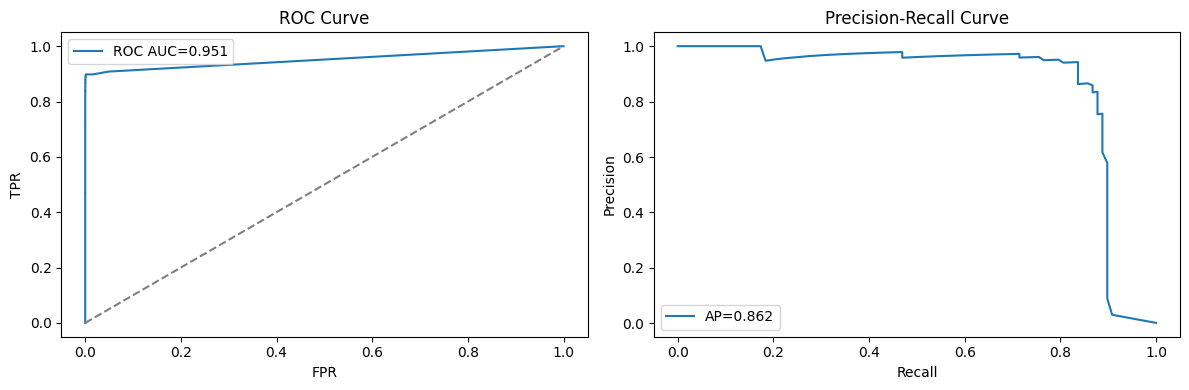

RF Threshold for ~80% recall: 0.37666666666666665
RandomForest @ ~80% recall @ threshold=0.37666666666666665
ROC-AUC: 0.95145 | PR-AUC (AP): 0.86224
Confusion Matrix:
 [[56859     5]
 [   19    79]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9405    0.8061    0.8681        98

    accuracy                         0.9996     56962
   macro avg     0.9701    0.9030    0.9340     56962
weighted avg     0.9996    0.9996    0.9996     56962



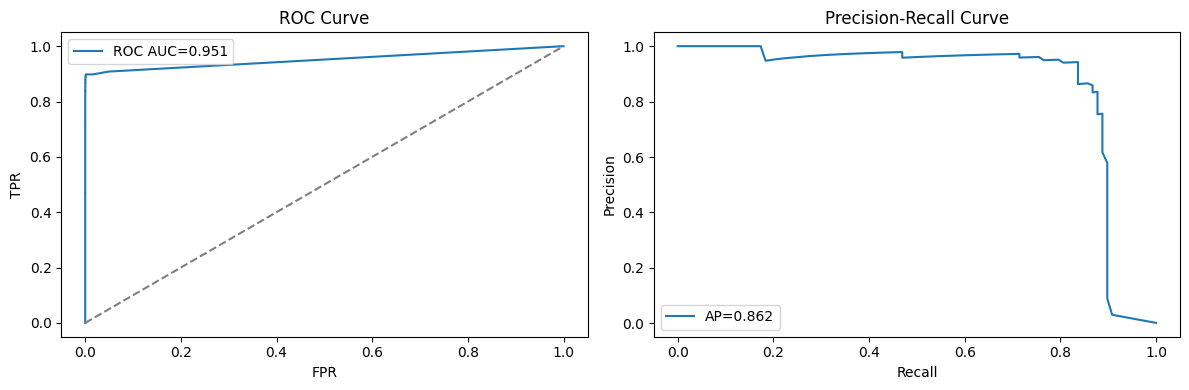

In [53]:
# 監督式學習：隨機森林（類別權重）
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]
metrics_rf = evaluate_classifier(y_test, rf_prob, threshold=0.5, title_prefix='RandomForest (balanced)')

prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, rf_prob)
thr_rf_80 = tune_threshold_by_recall(prec_rf, rec_rf, thr_rf, target_recall=0.80)
print('RF Threshold for ~80% recall:', thr_rf_80)
metrics_rf_80 = evaluate_classifier(y_test, rf_prob, threshold=thr_rf_80, title_prefix='RandomForest @ ~80% recall')


IsolationForest @ threshold=0.7502491561688046
ROC-AUC: 0.95305 | PR-AUC (AP): 0.17035
Confusion Matrix:
 [[56793    71]
 [   70    28]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988     56864
           1     0.2828    0.2857    0.2843        98

    accuracy                         0.9975     56962
   macro avg     0.6408    0.6422    0.6415     56962
weighted avg     0.9975    0.9975    0.9975     56962



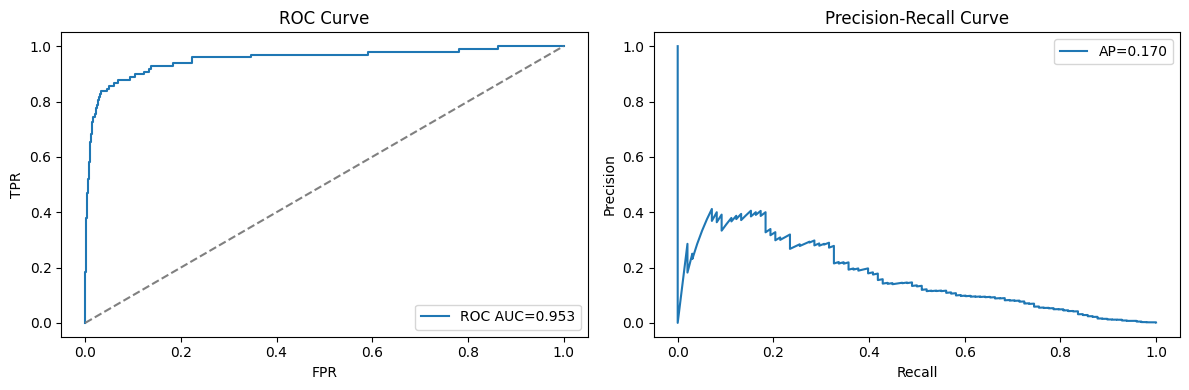

In [54]:
# 非監督/半監督：Isolation Forest
# 設定 contamination 為估計的詐欺比例（可用訓練集正例比例）
contam = float(y_train.mean())
iso = IsolationForest(
    n_estimators=300,
    contamination=contam,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

# IsolationForest 的 decision_function 值越大越正常；這裡我們取負號當作疑似詐欺的分數
iso_score = -iso.decision_function(X_test)
# 將分數線性縮放到 [0,1] 以利比較
iso_prob = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min() + 1e-9)

metrics_iso = evaluate_classifier(y_test, iso_prob, threshold=np.quantile(iso_prob, 1-contam), title_prefix='IsolationForest')


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF @ threshold=0.1921851953750392
ROC-AUC: 0.68795 | PR-AUC (AP): 0.00627
Confusion Matrix:
 [[56767    97]
 [   96     2]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9983    0.9983    0.9983     56864
           1     0.0202    0.0204    0.0203        98

    accuracy                         0.9966     56962
   macro avg     0.5093    0.5094    0.5093     56962
weighted avg     0.9966    0.9966    0.9966     56962



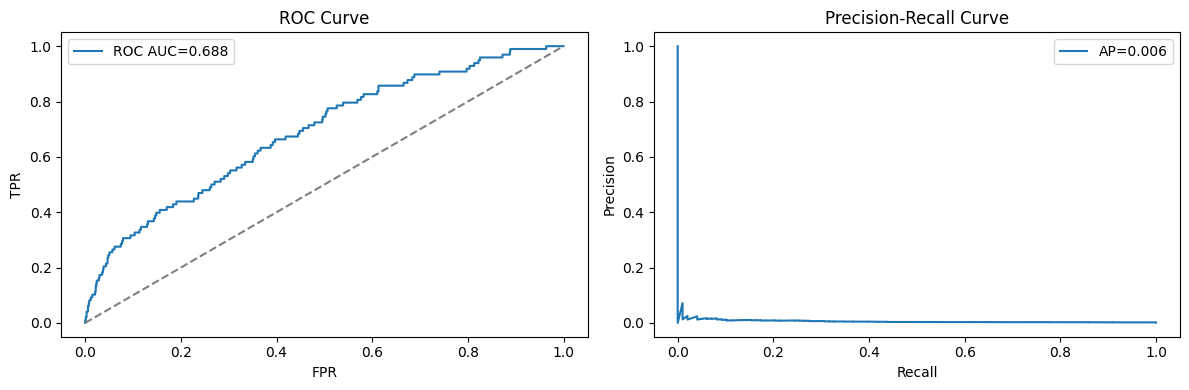

In [55]:
# 非監督/半監督：Local Outlier Factor (LOF)
# 使用 novelty=True 以便在測試集上打分
lof = LocalOutlierFactor(n_neighbors=35, novelty=True, contamination=contam, n_jobs=-1)
lof.fit(X_train)

lof_score = -lof.decision_function(X_test)
lof_prob = (lof_score - lof_score.min()) / (lof_score.max() - lof_score.min() + 1e-9)

metrics_lof = evaluate_classifier(y_test, lof_prob, threshold=np.quantile(lof_prob, 1-contam), title_prefix='LOF')


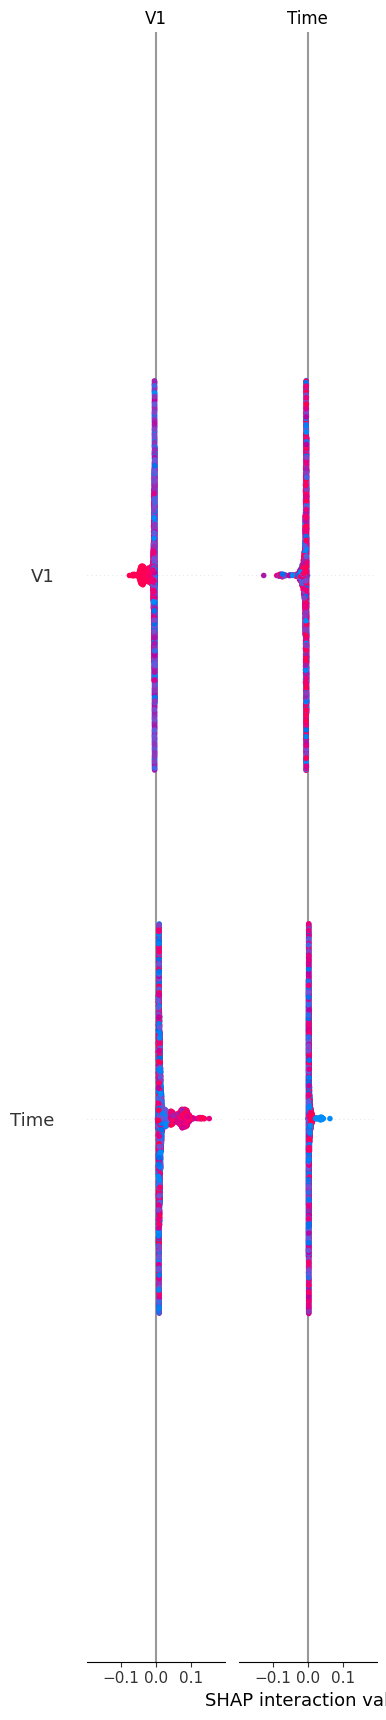

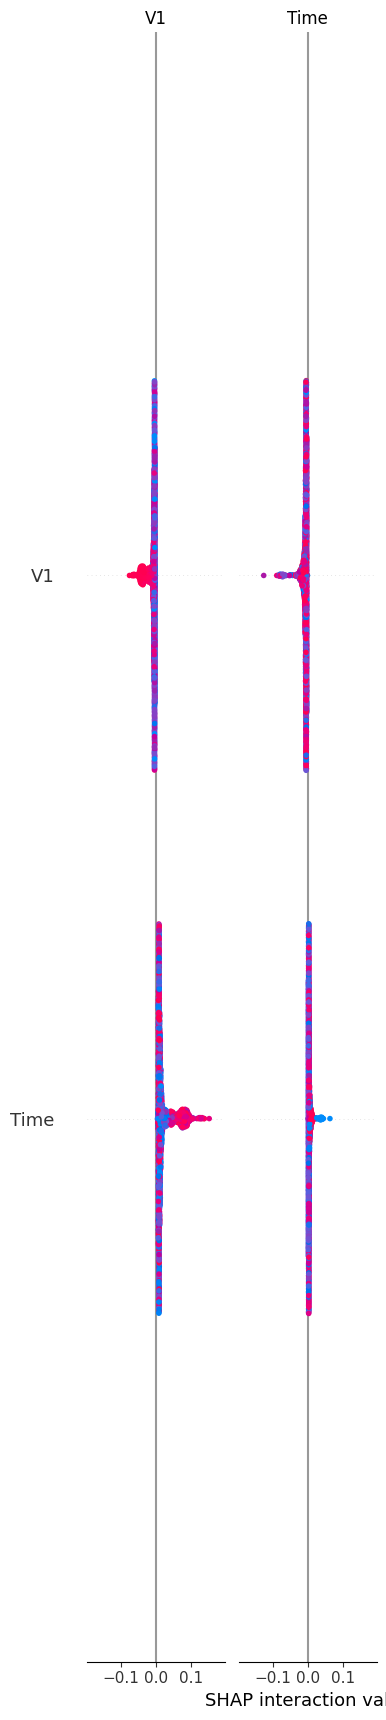

In [56]:
# SHAP：解釋隨機森林的重要度（取樣以節省時間）
# 注意：在高維且資料量大時，SHAP 可能較耗時
explainer = shap.TreeExplainer(rf)
# 取部分測試資料以加速
sample_idx = np.random.RandomState(42).choice(len(X_test), size=min(2000, len(X_test)), replace=False)
X_sample = X_test.iloc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# 兼容不同 SHAP 版本的輸出格式
if isinstance(shap_values, list):
    shap_arr = shap_values[1]
else:
    shap_arr = shap_values
# 某些版本會多一個偏置(常數)欄位，需去除
if shap_arr.shape[1] == X_sample.shape[1] + 1:
    shap_arr = shap_arr[:, :-1]

# 顯示前 20 個特徵的重要度摘要圖
shap.summary_plot(shap_arr, X_sample, plot_type='bar', max_display=20)
shap.summary_plot(shap_arr, X_sample, max_display=20)


In [57]:
# 結果彙整比較表
from collections import OrderedDict

rows = []
rows.append({'Model':'Logistic (0.5)', 'ROC-AUC': metrics_log['roc_auc'], 'PR-AUC': metrics_log['pr_auc']})
rows.append({'Model':'Logistic (~80%R)', 'ROC-AUC': metrics_log_80['roc_auc'], 'PR-AUC': metrics_log_80['pr_auc']})
rows.append({'Model':'RF (0.5)', 'ROC-AUC': metrics_rf['roc_auc'], 'PR-AUC': metrics_rf['pr_auc']})
rows.append({'Model':'RF (~80%R)', 'ROC-AUC': metrics_rf_80['roc_auc'], 'PR-AUC': metrics_rf_80['pr_auc']})
rows.append({'Model':'IsolationForest', 'ROC-AUC': metrics_iso['roc_auc'], 'PR-AUC': metrics_iso['pr_auc']})
rows.append({'Model':'LOF', 'ROC-AUC': metrics_lof['roc_auc'], 'PR-AUC': metrics_lof['pr_auc']})

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values('PR-AUC', ascending=False).reset_index(drop=True))


,Model,ROC-AUC,PR-AUC
0,RF (~80%R),0.951453,0.862235
1,RF (0.5),0.951453,0.862235
2,Logistic (~80%R),0.972083,0.718971
3,Logistic (0.5),0.972083,0.718971
4,IsolationForest,0.953046,0.170352
5,LOF,0.687952,0.006274
